In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import sys
from tqdm import tqdm

# sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
from glob import glob
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det

# from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel

import dropbox
from amftrack.util.dbx import upload_folders, download, read_saved_dropbox_state, save_dropbox_state, load_dbx, download, get_dropbox_folders, get_dropbox_video_folders
from subprocess import call
import logging

logging.basicConfig(stream=sys.stdout, level=logging.debug)

/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


/gpfs/scratch1/shared/amftrackflow/temp


In [5]:
d = {
    'x_res'         : [400],
    'y_res'         : [800],
    'nr_forw_lines' : [50],
    'nr_back_lines' : [50],
    'nr_stat_lines' : [10],
    'forw_intens'   : [10.0],
    'back_intens'   : [10.0],
    'stat_intens'   : [10.0],
    'forw_speed'    : [1.0],
    'back_speed'    : [1.0],
    'forw_width'    : [9.0],
    'back_width'    : [9.0],
    'stat_width'    : [1.0],
    'forw_speed_var': [0.3],
    'back_speed_var': [0.3],
    'forw_width_var': [1.0],
    'back_width_var': [2.0],
    'stat_width_var': [2.0],
}

dataframe = pd.DataFrame(d)

nr_tests = 10

expo_linspace = np.array( np.linspace(1, 1000, nr_tests))

dataframe.loc[0, 'nr_forw_lines'] = int(expo_linspace[0])
dataframe.loc[0, 'nr_back_lines'] = int(1001 - expo_linspace[0] )
# dataframe.loc[0, 'forw_speed_var'] = 1.0

for i in range(nr_tests-1):
    dataframe.loc[len(dataframe.index)] = dataframe.iloc[0]
    dataframe.loc[i+1, 'nr_forw_lines'] = int(expo_linspace[i+1])
    dataframe.loc[i+1, 'nr_back_lines'] = int(1001 - expo_linspace[i+1])
#     dataframe.loc[i+1, 'forw_speed_var'] = (9-i)/10

dataframe['nr_forw_lines'] = np.array(np.random.uniform(20, 200, nr_tests), dtype=int)
dataframe['nr_back_lines'] = np.array(np.random.uniform(20, 200, nr_tests), dtype=int)
dataframe['nr_stat_lines'] = np.array(np.random.uniform(1, 30, nr_tests), dtype=int)
dataframe['forw_intens']   = np.array(abs(np.random.normal(10, 4, nr_tests)))
dataframe['back_intens']   = np.array(abs(np.random.normal(10, 4, nr_tests)))
dataframe['stat_intens']   = np.array(abs(np.random.normal(10, 4, nr_tests)))
dataframe['forw_speed']    = np.array(np.random.normal(1.5, 1.5, nr_tests))
dataframe['back_speed']    = np.array(np.random.normal(1.5, 1.5, nr_tests))
dataframe['forw_width']    = np.array(np.random.normal(17, 5, nr_tests))
dataframe['back_width']    = np.array(np.random.normal(17, 5, nr_tests))
dataframe['stat_width']    = np.array(np.random.normal(17, 5, nr_tests))
dataframe['forw_speed_var']    = abs(np.array(np.random.normal(0.5, 0.2, nr_tests)))
dataframe['back_speed_var']    = abs(np.array(np.random.normal(0.5, 0.2, nr_tests)))
dataframe['forw_width_var']    = abs(np.array(np.random.normal(3, 1, nr_tests)))
dataframe['back_width_var']    = abs(np.array(np.random.normal(3, 1, nr_tests)))
dataframe['stat_width_var']    = abs(np.array(np.random.normal(3, 1, nr_tests)))

test_title = f"Scatterplot of transport tests"
test_xaxis = "Ground Truth Transport"

print(test_title)

dataframe


Scatterplot of transport tests


,x_res,y_res,nr_forw_lines,nr_back_lines,nr_stat_lines,forw_intens,back_intens,stat_intens,forw_speed,back_speed,forw_width,back_width,stat_width,forw_speed_var,back_speed_var,forw_width_var,back_width_var,stat_width_var
0,400.0,800.0,64,141,15,3.508115,9.757377,16.949034,1.820973,-2.424322,13.446440,12.701109,23.662474,0.300832,0.544763,2.113451,2.455262,4.958062
1,400.0,800.0,144,189,24,5.976020,9.873141,11.831391,1.536344,0.398051,14.720338,19.692198,18.284654,0.552724,0.903594,2.410102,1.638809,3.187350
2,400.0,800.0,86,166,29,8.545090,8.783500,8.094756,-0.412010,3.386620,14.609018,13.731989,24.849340,0.498929,0.346347,2.423481,1.927253,2.301511
3,400.0,800.0,133,32,8,4.980914,6.001862,9.105414,-0.611721,2.177639,18.236821,16.269945,14.213923,0.304680,0.452752,3.624058,1.357330,1.996275
4,400.0,800.0,55,50,4,13.415095,7.228773,7.706295,-0.153411,1.541420,19.367352,21.881277,22.719277,0.168839,0.419251,3.574668,4.342626,4.152641
5,400.0,800.0,149,79,22,10.675022,7.930280,8.580997,2.052675,2.671935,13.374261,1.666079,14.840354,0.203737,0.417784,3.829653,1.789938,4.111081
6,400.0,800.0,91,192,25,17.870520,5.701096,13.185885,2.405609,-0.822929,22.993118,25.035950,16.550888,0.248837,0.266050,4.248641,3.927799,1.743253
7,400.0,800.0,66,152,18,0.074888,3.474295,4.275467,-1.087586,1.613969,11.058695,10.865566,13.350579,0.444418,0.351792,3.066127,2.812452,4.282295
8,400.0,800.0,56,68,15,9.681992,11.202041,13.633308,2.019839,-0.814396,12.920095,13.564720,18.357430,0.402523,0.680549,2.191693,3.397630,1.795387
9,400.0,800.0,59,120,11,11.423531,2.604757,6.918842,-0.074751,3.206408,20.316674,21.255752,23.174701,0.256884,0.542901,2.677497,1.499895,2.284546


In [6]:
directory_targ = '/gpfs/home6/svstaalduine/Huh/'

In [7]:
run_parallel(
    "line_test_slurm.py",
    [directory_targ, 10],
    dataframe,
    32,
    "10:00:00",
    "line_test"
)

Sending jobs with id 1683193315434966650


In [7]:
plot_range= 3000

dataframe = pd.read_json("/gpfs/scratch1/shared/amftrackflow/temp/1682321952951926320.json")


In [8]:

files_list = glob(os.path.join(directory_targ, '1682321952951926320_*_line_test.json'))

import matplotlib.cm as cmx

total_lines = dataframe['nr_forw_lines'] * dataframe['forw_intens'] + dataframe['nr_back_lines'] * dataframe['back_intens']
line_group = total_lines // 100
total_spd_var = dataframe['forw_speed_var'] + dataframe['back_speed_var']
total_width_var = dataframe['forw_width_var'] + dataframe['back_width_var'] + dataframe['stat_width_var']
line_ratio = (dataframe['nr_forw_lines'] * dataframe['forw_intens']) / (dataframe['nr_back_lines'] * dataframe['back_intens'])
speed_ratio = dataframe['forw_speed'] / dataframe['back_speed']
high_speed = dataframe['back_speed'] > 2
test_index = np.arange(nr_tests)

line_means = dataframe.groupby(line_group).mean()
print(line_means)

value_interest = total_lines
cbar_string = 'Total number of lines times intensity'


      x_res  y_res  nr_forw_lines  nr_back_lines  nr_stat_lines  forw_intens  \
0.0   400.0  800.0      94.333333      50.333333      12.000000     0.351328   
1.0   400.0  800.0      26.000000      21.000000      29.000000     5.034565   
2.0   400.0  800.0      62.416667      53.500000      16.500000     4.451445   
3.0   400.0  800.0      47.552632      67.710526      17.868421     5.768594   
4.0   400.0  800.0      55.225352      47.676056      14.140845     5.976631   
...     ...    ...            ...            ...            ...          ...   
59.0  400.0  800.0     174.500000     171.500000      23.500000    13.788777   
60.0  400.0  800.0     196.000000     148.000000      14.000000    17.280262   
61.0  400.0  800.0     182.000000     170.000000       1.500000    16.225984   
62.0  400.0  800.0     161.000000     129.000000      23.000000    19.640833   
63.0  400.0  800.0     196.000000     188.500000      22.000000    17.693550   

      back_intens  stat_intens  forw_sp

In [9]:
print(max(line_group))

63.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [04:18<00:00, 31.70it/s]


Text(0.5, 1.0, 'Error plot')

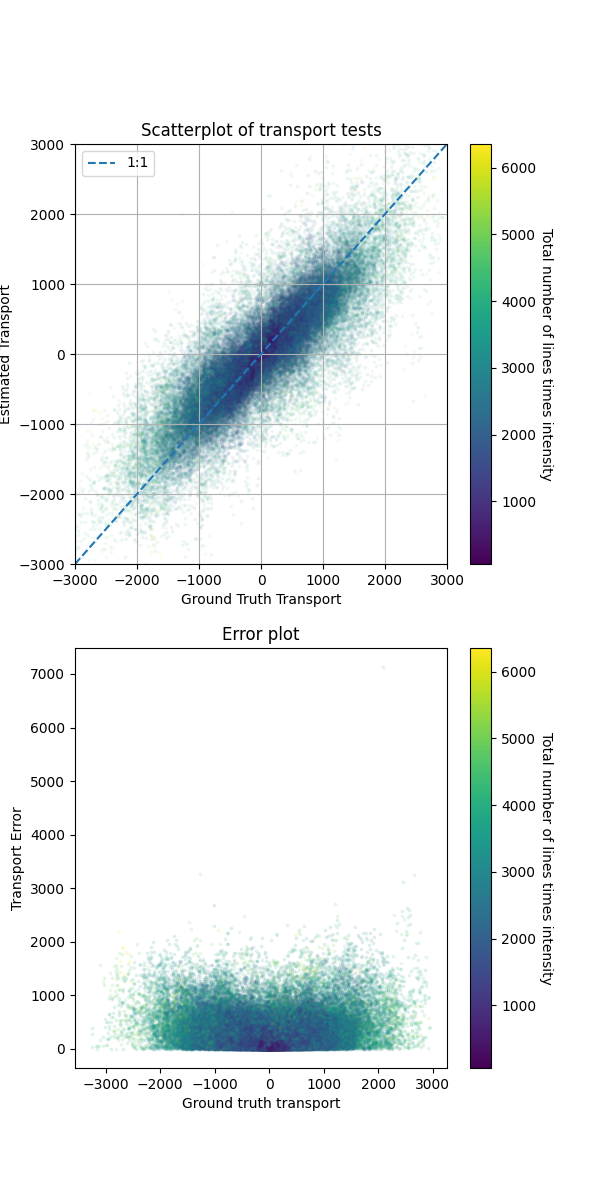

In [10]:
# print(total_lines.max())
jet = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=value_interest.min(), vmax=value_interest.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# print(len(files_list))
fig, ax = plt.subplots(2, figsize = (6,6*2))

for i, file in enumerate(tqdm(sorted(files_list))):  
    file_int = int(file.split('/')[-1].split('_')[-3])
#     print(int(file.split('/')[-1].split('_')[-3]))
    res = pd.read_json(file)
    
    colorVal = scalarMap.to_rgba(value_interest[i])
    
    if i == 0:
        est_res = pd.DataFrame(res.iloc[0]).T
        grt_res = pd.DataFrame(res.iloc[1]).T
        histo_counts, histo_bins = np.histogram((res.iloc[0] - res.iloc[1]), bins = 50, range=(0, 2000))
    else:
        est_res = pd.concat([est_res, pd.DataFrame(res.iloc[0]).T], ignore_index=True)
        grt_res = pd.concat([grt_res, pd.DataFrame(res.iloc[1]).T], ignore_index=True)
        histo_count, _ = np.histogram((res.iloc[0] - res.iloc[1]), bins = 50, range=(0, 2000))
        histo_counts += histo_count
    error_frame = abs(res.iloc[0] - res.iloc[1]).T
    
    ax[0].scatter(pd.DataFrame(res.iloc[1]).T, pd.DataFrame(res.iloc[0]).T, s=3, color=colorVal, alpha=0.05)
    ax[1].scatter(pd.DataFrame(res.iloc[1]).T, error_frame, s=3, color=colorVal, alpha=0.1)
#     ax[3].scatter([total_lines[i]]*10, error_frame)
ax[0].plot([-plot_range, plot_range], 
        [-plot_range, plot_range], label='1:1', linestyle='dashed')
ax[0].set_xlim(-plot_range, plot_range)
ax[0].set_ylim(-plot_range, plot_range)
ax[0].legend()
ax[0].grid(True)
ax[0].set_title(test_title)
ax[0].set_xlabel(test_xaxis)
ax[0].set_ylabel("Estimated Transport")
cbar = fig.colorbar(scalarMap, ax=ax[0])
cbar1 = fig.colorbar(scalarMap, ax=ax[1])
cbar.set_label(cbar_string, rotation=270, labelpad = 12)
cbar1.set_label(cbar_string, rotation=270, labelpad = 12)
ax[1].set_xlabel('Ground truth transport')
ax[1].set_ylabel('Transport Error')
ax[1].set_title('Error plot')



Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
              22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0,
              33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0,
              44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0,
              55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0],
             dtype='float64')


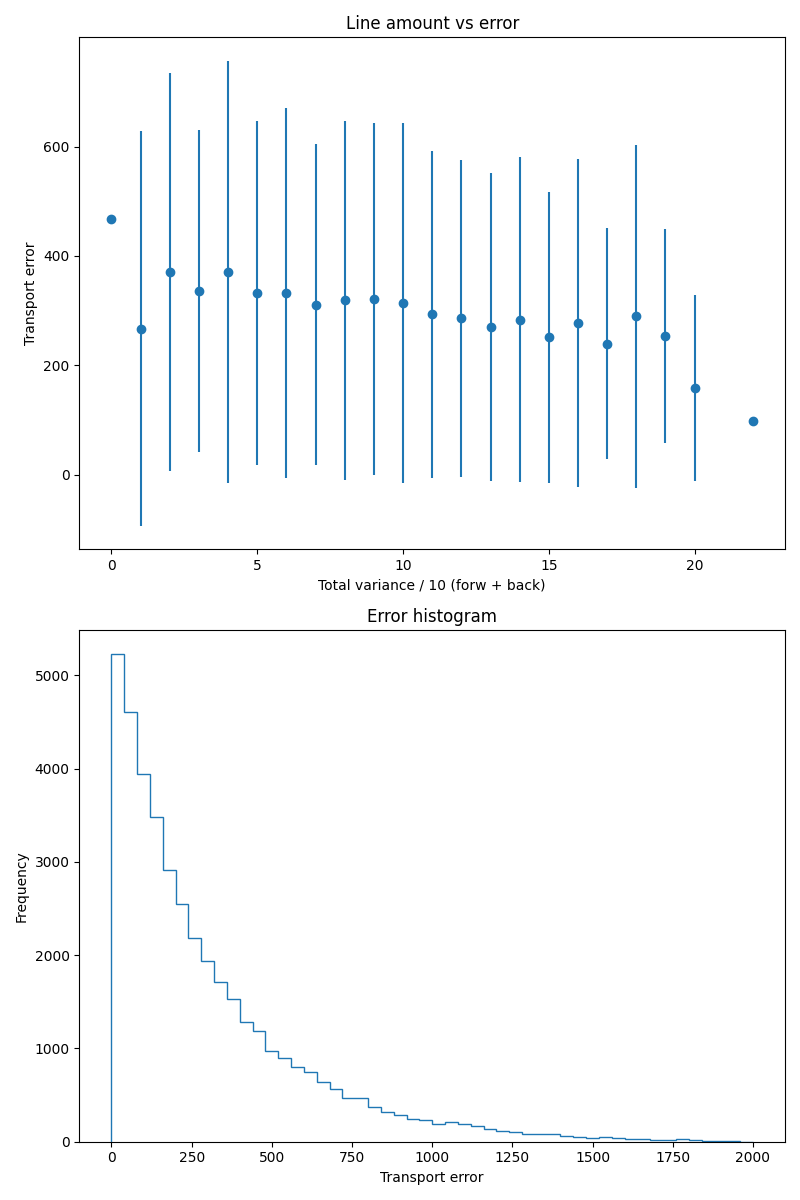

In [15]:
fig, ax = plt.subplots(2, figsize = (8,8*1.5))

line_group = total_lines // 100
total_speed = dataframe['forw_speed'] + dataframe['back_speed']
total_speed_group = total_speed // 1

total_var = dataframe['forw_speed_var'] + dataframe['back_speed_var']
total_var_group = total_var * 10 // 1

error_frames = abs(grt_res - est_res)
line_group_means = error_frames.groupby(line_group).mean().mean(axis=1)
line_group_stds = error_frames.groupby(line_group).std().mean(axis=1)

total_speed_group_means = error_frames.groupby(total_speed_group).mean().mean(axis=1)
totat_speed_group_stds = error_frames.groupby(total_speed_group).std().mean(axis=1)

total_var_group_means = error_frames.groupby(total_var_group).mean().mean(axis=1)
total_var_group_stds = error_frames.groupby(total_var_group).std().mean(axis=1)


means_interest = total_var_group_means
std_interest = total_var_group_stds

ax[0].errorbar(means_interest.index, means_interest, std_interest, fmt='o')

ax[1].stairs(histo_counts, histo_bins)

# x_axis = (dataframe['nr_forw_lines'] / dataframe['nr_back_lines']).to_numpy()
# x_axis = dataframe['nr_forw_lines'].to_numpy()*2
estim = est_res.to_numpy()
grdtr = grt_res.to_numpy()
# print(estim)

# ax[0].errorbar(x_axis, est_res.mean(axis=1), yerr=est_res.std(axis=1), label='Estimated', fmt='o')
# ax.scatter(grdtr.T, estim.T)
# ax[0].errorbar(x_axis, grt_res.mean(axis=1), yerr=grt_res.std(axis=1), label='Ground Truth', fmt='o')
# # ax.set_xscale('log')

ax[1].set_xlabel('Transport error')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Error histogram')
ax[0].set_xlabel('Total variance / 10 (forw + back)')
ax[0].set_ylabel('Transport error')
ax[0].set_title('Line amount vs error')
# fig.suptitle("Transport total line amount")
fig.tight_layout()


print(line_group_stds.index)
